# Introduction

------------------------------------------------

Wildfires can have many causes, which are determined by expert investigators.  Sometimes, the cause of a fire is obvious: an eyewitness account of arsonists leaving the scene of the crime. However it isn't always an open and shut case nor is it always arson. Other causes can be debris burning, equipment use, lightning, or a campfire gone awry. An investigation is always required. Can machine learning algorithms assist investigators of wildfires?  This is the question I set out to explore. 



In order to build a model, data is required; the more data the better. Mercifully, there’s a fairly clean dataset of over a million wildfires found on Kaggle.  The dataset has many variables. However, not all given variables will be used in the model. Furthermore, part of the art of model building entails bringing in extra variables from different datasets.

A very reasonable feature to include in the modeling process is weather. Getting the weather for 1.88 million rows of data was the most challenging part of the project for a novice coder like myself. Trial and error on 1.88 million rows of data will take forever to compute. Fortunately, I thought of clever shortcuts which are detailed in the notebook. 



Modeling is developed iteratively. In other words,  a base model whose measures of veracity are overall improved with sequential modeling decisions, leading to new models.  At the very least, the model should be better than chance. In a binary classification model, accuracy should be better than 50%.  The base model here gives the right answer 61% of the time, and is a simple logistic model without exogenous features.



For evaluating our model simplistically, we can look at accuracy. The number of observations correctly classified over the total possible number of observations is accuracy.  This is also called the True Positive rate.  Further metrics to get a comprehensive picture of model performance are detailed in the notebook.


-----------------------------------------

# Import Necessary Packages and Modules Here

-------------------------

In [1]:

from math import sin, cos, sqrt, atan2, radians

import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from collections import OrderedDict

import sqlite3

import datetime

import operator

import requests

import sklearn.neighbors

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

-------------------------

# Data Preparation For the Feature of Weather

---------------------------------------

## A Function To Get NOAA Stations

NOAA is the National Oceanic and Atmospheric Administration for the USA. I always thought that was a good acronym for an organization concerned with weather.  NOAA sounds like Noah, the protagonist in the Biblcial Flood story, and a flood is an extreme weather event. But I digress.

NOAA has weather stations all across the United States. NOAA also makes its historical weather data free to use. Therefore, NOAA is a natural choice for getting historical weather conditions for a data science project. My objective is to get the historical weather conditions for 1.88 million wildfires from 1992 to 2015. This objective is do-able, but requires breaking it down into smaller tasks. 

First, I need a list of all the weather stations and their geographic coordinates. However this list wasn't available. I would have to create this list myself.  Fortunately, NOAA lets you download a spreadsheet for the weather on a single day in any state.  It's a request I make on the website and only takes a few minutes to process. When my request is processed, I am sent a link to a website, with the cvs file. This is not an API request. It's manually navigating buttons on a website, done fifty times. 

Then I created a function that will quickly visit these websites, change the cvs file into a dataframe, extract the relevant data, and put that into a new dataframe. These urls will be defunct after a time period. For ease of reproducibility, the function saves its results in a cvs file on the computer.   

In [2]:
def NOAA_stations(url):
    
    df = pd.read_csv(url)

    # Backup csv file from the web
    df.to_csv(url[-11:], index=False)

    api_station_name = ['GHCND:' + i for i in df.STATION.values]

    api_station_state = [df.NAME[0][-5:-3] for i in range(len(df))]
    
    api_station_latitude = df.LATITUDE

    api_station_longitude = df.LONGITUDE

    columns = ['name', 'state', 'latitude', 'longitude']

    data = [api_station_name, api_station_state,
            api_station_latitude, api_station_longitude]

    data = dict(zip(columns, data))

    return pd.DataFrame(data)

Backup the function's results

NOAA_stations_df = pd.concat(df_list, axis = 0)
NOAA_stations_df.to_csv('NOAA_stations_df.csv', index = False)

-----------------------------------------------------------------------------------------

##   Import NOAA Weather Stations & Locations

In [3]:
NOAA_stations_df = pd.read_csv('NOAA_stations_df.csv')
NOAA_stations_df.drop('index', axis = 1, inplace = True)

# The magic of rounding

At this point, we have a list of all the NOAA weather stations in the United States, with their precise geographic coordinates. We can now determine which station is closer to which wildfire. This will be done through trial and error. However, without using any shortcuts it will take too long.  A major shortcut is rounding.  

In our dataset, the coordinates of wildfires is give to several decimal places. However there are way fewer weather stations than wildfire incidents.  We won't actually lose that much information, if we round the wildfires' coordinates to the ones place.  The number of unique locations drops a lot.

Importing the original dataset of wildfires data from Kaggle. This is a very large dataset.  Therefore, you must download it into your own computer.  Find it on https://www.kaggle.com/rtatman/188-million-us-wildfires

In [4]:
conn = sqlite3.connect('wildfires.sqlite')

cur = conn.cursor()

df = pd.read_sql_query("select * from fires;", conn)

df.to_csv('wildfires.csv', index=False)

In [5]:
df = pd.read_csv("wildfires.csv")

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
wildfires_coordinates_df = df[['OBJECTID','STATE','LATITUDE','LONGITUDE']]

In [7]:
print("The number of observations " ,len(df))

print("The number of unique latitudes " ,len(set(wildfires_coordinates_df.LATITUDE)))

rounding_effects_lat = [len(set(wildfires_coordinates_df.LATITUDE.round(i))) for i in range(9)]

print("How the number of unique latitudes changes with rounding ")
print(rounding_effects_lat)

The number of observations  1880465
The number of unique latitudes  894061
How the number of unique latitudes changes with rounding 
[48, 434, 3896, 30189, 221206, 694384, 843160, 863127, 894061]


This is a subset of the original dataset with only the features we need for finding the closest weather stations.

In [8]:
wildfires_coordinates_df['LATITUDE'] = wildfires_coordinates_df.LATITUDE.round()

wildfires_coordinates_df['LONGITUDE'] = wildfires_coordinates_df.LONGITUDE.round()

<ipython-input-8-a5abb5ad7a92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_coordinates_df['LATITUDE'] = wildfires_coordinates_df.LATITUDE.round()
<ipython-input-8-a5abb5ad7a92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_coordinates_df['LONGITUDE'] = wildfires_coordinates_df.LONGITUDE.round()


Now that the latitudes and longitudes are rounded, some geographic coordinates may be repeated. 
In order to find the unique coordinates, we have to look at latitude and longitude together for each observation.
Therefore we will turn them into tuples. 

In [9]:
lat_long_tups = list(zip(wildfires_coordinates_df.LATITUDE.values ,wildfires_coordinates_df.LONGITUDE.values))

wildfires_coordinates_df['LAT_LONG'] = lat_long_tups

<ipython-input-9-01b0add0e647>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_coordinates_df['LAT_LONG'] = lat_long_tups


-------------------------------------------------------------------

# Creating a Dictionary: Wildfire coordinates to OrderIDs

We make a dictionary that has the unique tuples and all the objectids assocaited with them.

In [10]:
lat_long_tups_unique = wildfires_coordinates_df.LAT_LONG.value_counts()


lat_long_tups_unique = list(lat_long_tups_unique.index)


values = [wildfires_coordinates_df[wildfires_coordinates_df.LAT_LONG ==
                                   i].OBJECTID.values for i in lat_long_tups_unique]

geo_dict = dict(zip(lat_long_tups_unique, values))

---------------------------------------------------------------

# Creating a Dictionary of OrderIDs to other OrderIDs.

The values in the code below are all the OrderIDs which share a common geographic coordinate for their wildfire. It follows, that a single orderID can act as a key for all the orderIDs, including itself which have the same wildfire coordinates. 

In [11]:
new_keys = [i[0] for i in values]

orderID_group_dict = dict(zip(new_keys,values))

-----------------------------------------------------------------

# Haversian Distance

Calculating the distance between two points on a sphere requires some special mathematics.  Fortunately there are functions already made to calculate such distances, called Haversian distances.  Calculations with Haversian distances are done in radians. Latitude and longitude must be converted into radians. I adapted the code from this resource on Haversian Distances:   https://codeburst.io/calculate-haversine-distance-between-two-geo-locations-with-python-439186315f1b

In [12]:
NOAA_stations_df[['lat_radians_Y', 'long_radians_Y']] = (
    np.radians(NOAA_stations_df.loc[:, ['latitude', 'longitude']]))


Places_X = pd.DataFrame({'OBJECTID': [i[0] for i in values],
                         'latitude': [i[0] for i in lat_long_tups_unique],
                         'longitude': [i[-1] for i in lat_long_tups_unique]})


Places_X[['lat_radians_X', 'long_radians_X']] = np.radians(
    Places_X.loc[:, ['latitude', 'longitude']])

dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')

dist_matrix = (dist.pairwise
               (Places_X[['lat_radians_X', 'long_radians_X']],
                NOAA_stations_df[['lat_radians_Y', 'long_radians_Y']])*3959
               )

df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=Places_X['OBJECTID'], 
                 columns=NOAA_stations_df['name'])
)


df_dist_unpv = (
    pd.melt(df_dist_matrix.reset_index(),id_vars='OBJECTID')
)


In [13]:
k_list = []

station_name_dict = {}

for k, v in orderID_group_dict.items():

   # put a print statement to know something is running
    
    k_list.append(k)
    
    count = len(k_list)
    
    print(count/1232)

    subset = df_dist_unpv.OBJECTID == k
    
    closest_staton_name = df_dist_unpv.loc[(df_dist_unpv['OBJECTID']==k)].sort_values(by = 'value').head(1).name.values[0]

    station_name_dict[k] = closest_staton_name

0.0008116883116883117
0.0016233766233766235
0.002435064935064935
0.003246753246753247
0.004058441558441558
0.00487012987012987
0.005681818181818182
0.006493506493506494
0.007305194805194805
0.008116883116883116
0.008928571428571428
0.00974025974025974
0.010551948051948052
0.011363636363636364
0.012175324675324676
0.012987012987012988
0.013798701298701298
0.01461038961038961
0.015422077922077922
0.016233766233766232
0.017045454545454544
0.017857142857142856
0.018668831168831168
0.01948051948051948
0.020292207792207792
0.021103896103896104
0.021915584415584416
0.022727272727272728
0.02353896103896104
0.024350649350649352
0.025162337662337664
0.025974025974025976
0.026785714285714284
0.027597402597402596
0.028409090909090908
0.02922077922077922
0.030032467532467532
0.030844155844155844
0.03165584415584415
0.032467532467532464
0.033279220779220776
0.03409090909090909
0.0349025974025974
0.03571428571428571
0.036525974025974024
0.037337662337662336
0.03814935064935065
0.03896103896103896
0.0

# Looking between dictionaries

In [14]:
master_dict = {}

for k,v in station_name_dict.items():

    for key in orderID_group_dict[k]:
        
        master_dict[key] = v

In [15]:

master_dict = OrderedDict(sorted(master_dict.items()))

# Grand Finale - Making the Closest Weather Station  a Feature

In [16]:
wildfires_coordinates_df['NOAA'] = list(master_dict.values())

<ipython-input-16-42a37cf195ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_coordinates_df['NOAA'] = list(master_dict.values())


# Converting Julian Dates to Standard Dates

In [17]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [18]:
wildfires_coordinates_df['DISCOVERY_DATE'] = df['DISCOVERY_DATE']

wildfires_coordinates_df['DURATION'] = df.CONT_DATE - df.DISCOVERY_DATE

wildfires_coordinates_df['DURATION'].fillna(
    pd.Timedelta(seconds=0), inplace=True)

wildfires_coordinates_df['DURATION'] = [
    int(str(i)[0:2]) for i in wildfires_coordinates_df.DURATION]

<ipython-input-18-123726ef4b22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_coordinates_df['DISCOVERY_DATE'] = df['DISCOVERY_DATE']
<ipython-input-18-123726ef4b22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_coordinates_df['DURATION'] = df.CONT_DATE - df.DISCOVERY_DATE
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

# Save the DataFrame 

In [19]:
wildfires_coordinates_df.to_csv('wildfires_coordinates_df', index=False)

----------------------

# Adding a Feature of Month

In [20]:
wildfires_coordinates_df = pd.read_csv('wildfires_coordinates_df')

wildfires_coordinates_df['year'] = pd.DatetimeIndex(
    wildfires_coordinates_df.DISCOVERY_DATE).year

# EDA about Causes of Wildfire

In [21]:
df.STAT_CAUSE_DESCR.value_counts(normalize = True)

Debris Burning       0.228150
Miscellaneous        0.172194
Arson                0.149673
Lightning            0.148085
Missing/Undefined    0.088661
Equipment Use        0.078498
Campfire             0.040489
Children             0.032528
Smoking              0.028115
Railroad             0.017791
Powerline            0.007683
Fireworks            0.006116
Structure            0.002019
Name: STAT_CAUSE_DESCR, dtype: float64

## Barplot

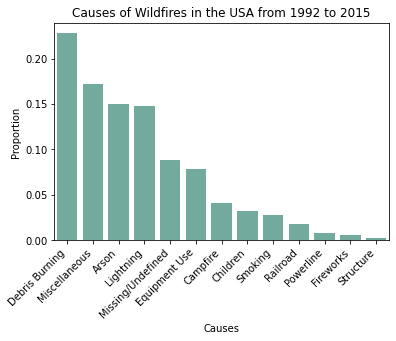

In [22]:
barplot_df = pd.DataFrame({'Causes' :list(df.STAT_CAUSE_DESCR.value_counts(normalize = True).index) , 'Proportion' : list(df.STAT_CAUSE_DESCR.value_counts(normalize = True).values)})



barplot_df = barplot_df.sort_values(['Proportion'], ascending=False).reset_index(drop=True)

chart = sns.barplot(
    x='Causes', 
    y='Proportion', 
    data=barplot_df, 
    estimator=sum, 
    ci=None, 
 
    color='#69b3a2'
);


chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.title('Causes of Wildfires in the USA from 1992 to 2015');


# Which  and When

## Which State had the most fires and in which year? 

In [23]:
groups = wildfires_coordinates_df.groupby(['year', 'STATE']).count().OBJECTID

unstack_df = groups.unstack()

unstack_df.fillna(0, inplace=True)

In [24]:
state_dict = dict(zip(list(unstack_df.columns), [max(
    unstack_df[i]) for i in list(unstack_df.columns)]))

max_value = max(state_dict.values())

max_key = max(state_dict.items(), key=operator.itemgetter(1))[0]


print('The most wildires in a single year was ' +
      str(round(max_value)) + ',' + ' occurring in ' + str(max_key) + '.')

The most wildires in a single year was 19453, occurring in TX.


In [25]:
Texas_df = wildfires_coordinates_df[wildfires_coordinates_df.STATE == 'TX']

In [26]:
year_dict = dict(zip(Texas_df.groupby(['year']).count(
).OBJECTID.index, Texas_df.groupby(['year']).count().OBJECTID.values))

max_value = max(year_dict.values())

max_key = max(year_dict.items(), key=operator.itemgetter(1))[0]

print('The year with ' + str(max_value) +
      ' wildfires was ' + str(max_key) + '.')

The year with 19453 wildfires was 2011.


In [27]:
Texas_2011_df = Texas_df[Texas_df.year == 2011]

---------------------------------------------------

# Get Features & Target

## API Call for Weather Tempertures

### API function

In [28]:
def get_weather(datasetid, stationid, startdate, enddate, datatypeid ,limit, token):

    token = {'token': token}

    params = 'datasetid=' + datasetid + '&' + 'stationid=' + stationid + '&' + \
        'startdate=' + str(startdate) + '&' + 'enddate=' + \
        str(enddate) + '&' + 'datatypeid=' + datatypeid + '&' + 'limit=' + str(limit)

    r = requests.get(base_url, params=params, headers=token)

    print("Request status code: "+ str(r.status_code))

    return json.loads(r.text)

## API Weather data

In [29]:
station_list = set(Texas_2011_df.NOAA)

station_list_dict = dict(enumerate(station_list))

In [30]:
token = 'wtvrEYejcUwYDltcGRmzjkkHkxEhQfor'

base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data?"

startdate = '2011-01-01'

enddate = '2011-12-31'

datatypeid = 'TMAX'

results = [get_weather('GHCND', i, startdate, enddate, datatypeid , 1000 , token ) for i in station_list] 

Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200
Request status code: 200


## Subset dataframe based on available weather station data from the API call

In [31]:
station_result_dict = dict(
    enumerate([len(results[i]) != 0 for i in range(len(station_list))]))

conditions = []

for k, v in station_list_dict.items():
    if station_result_dict[k] == True:
        conditions.append(v)

In [32]:
Texas_2011_df_ready = pd.concat([Texas_2011_df[Texas_2011_df.NOAA == i] for i in conditions], axis = 0)

## Turn api results into a dataframe

In [33]:
filtered = [k for k in station_result_dict.keys() if station_result_dict[k] == True]

In [34]:
api_result_df_list = []

for i in filtered:

    api_result_df = pd.DataFrame(results[i]['results'])

    api_result_df.drop('attributes', axis=1, inplace=True)

    api_result_df['date'] = pd.to_datetime(
        api_result_df['date'], format='%Y-%m-%d')

    api_result_df_list.append(api_result_df)

api_result_df = pd.concat(api_result_df_list)

In [35]:
# Make a nested dictionary to make it easier to enter Temperture data for modeling
# first key is noaa station the values are the keys of dates, whose values are the temperture readings.

keys = list(api_result_df.station)

feature_making_dict = {}

for i in keys:

    feature_making_dict[i] = ''

    pre_dict_df = api_result_df[api_result_df.station ==
                                i][['date', 'value']]
    dict2 = dict(zip(pre_dict_df.date, pre_dict_df.value))

    feature_making_dict[i] = dict2


### Creating the Temperture Feature in the data

I need to lookup keys in a nested dictionary.

In [36]:
def df_row(row_number):
    return Texas_2011_df_ready[['NOAA', 'DISCOVERY_DATE']].iloc[row_number, ]

In [37]:
# this gives me the two keys in the nested dictionary...

TMAX = [feature_making_dict.get(df_row(i)[0]).get(pd.to_datetime(df_row(i)[1])) for i in range(len(Texas_2011_df_ready))]

In [38]:
Texas_2011_df_ready['TMAX'] = TMAX


In [39]:
df_features = Texas_2011_df_ready

## Getting the Fire Cause, Day of the Year Feature, Time of Fire, & Fire Size From Original Dateset

In [94]:
wildfires_df = pd.read_csv('wildfires.csv')

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [95]:
objectID_needed = df_features.OBJECTID.values

fire_cause_dict = dict(zip(wildfires_df.OBJECTID.values, wildfires_df.STAT_CAUSE_DESCR))

DOY_dict = dict(zip(wildfires_df.OBJECTID.values, wildfires_df.DISCOVERY_DOY))

TIME_dict = dict(zip(wildfires_df.OBJECTID.values, wildfires_df.DISCOVERY_TIME))

fire_size_dict = dict(zip(wildfires_df.OBJECTID.values, wildfires_df.FIRE_SIZE))

df_features['STAT_CAUSE_DESCR'] = [fire_cause_dict.get(i) for i in objectID_needed]

df_features['DISCOVERY_DOY'] = [DOY_dict.get(i) for i in objectID_needed]

df_features['DISCOVERY_TIME'] = [TIME_dict.get(i) for i in objectID_needed]

df_features['month'] = pd.DatetimeIndex(df_features['DISCOVERY_DATE']).month

df_features['FIRE_SIZE'] = [fire_size_dict.get(i) for i in objectID_needed]

In [96]:
df_features.head() 

,OBJECTID,STATE,LATITUDE,LONGITUDE,LAT_LONG,NOAA,DISCOVERY_DATE,DURATION,year,TMAX,STAT_CAUSE_DESCR,DISCOVERY_DOY,DISCOVERY_TIME,month,FIRE_SIZE
1470827,1470828,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-04-06,0,2011,222.0,Arson,96,1545.0,4,0.1
1470830,1470831,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-03-09,0,2011,239.0,Equipment Use,68,1315.0,3,2.0
1524362,1524363,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-01-06,0,2011,139.0,Equipment Use,6,1524.0,1,65.0
1524378,1524379,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-01-19,1,2011,106.0,Equipment Use,19,1530.0,1,6.0
1524381,1524382,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-01-25,0,2011,128.0,Debris Burning,25,1345.0,1,10.0


In [97]:
data_df = df_features[(df_features.STAT_CAUSE_DESCR != 'Missing/Undefined')]

In [98]:
set(data_df.STAT_CAUSE_DESCR)

{'Arson',
 'Campfire',
 'Children',
 'Debris Burning',
 'Equipment Use',
 'Fireworks',
 'Lightning',
 'Miscellaneous',
 'Powerline',
 'Railroad',
 'Smoking'}

# Using Statistics or Data Understanding For Feature Hunting

We can use basic principles from statistics to guide feature creation and feature selection.  Differences in how variables are distibuted amongst the various classes suggest those variables make good predictive features.

## Do the months' favor different causes? 

In [99]:
set(data_df.STAT_CAUSE_DESCR)

{'Arson',
 'Campfire',
 'Children',
 'Debris Burning',
 'Equipment Use',
 'Fireworks',
 'Lightning',
 'Miscellaneous',
 'Powerline',
 'Railroad',
 'Smoking'}

In [100]:
month_and_cause_df = data_df[['month', 'STAT_CAUSE_DESCR']]

In [101]:
causes_set = set(month_and_cause_df.STAT_CAUSE_DESCR)


df_list = [month_and_cause_df[month_and_cause_df.STAT_CAUSE_DESCR ==
                              i].groupby('month').count() for i in causes_set]


month_and_cause_df = pd.concat(df_list, axis = 1)

month_and_cause_df.columns = causes_set

In [102]:
month_and_cause_df.fillna(0, inplace = True)

month_and_cause_df

,Children,Railroad,Miscellaneous,Lightning,Debris Burning,Smoking,Campfire,Powerline,Arson,Fireworks,Equipment Use
month,,,,,,,,,,,
1,9,3.0,202,5.0,289,12,8,23,26,0.0,94
2,13,1.0,187,1.0,307,14,21,35,35,0.0,91
3,11,2.0,216,11.0,270,20,19,42,44,0.0,105
4,8,7.0,224,41.0,165,32,7,93,61,0.0,115
5,5,0.0,136,41.0,105,9,5,37,26,0.0,109
6,10,8.0,187,107.0,149,30,6,53,32,0.0,145
7,10,5.0,253,119.0,137,31,8,49,37,2.0,147
8,10,7.0,272,171.0,123,41,1,109,79,0.0,159
9,3,5.0,287,121.0,139,28,7,94,71,0.0,154


In [103]:
from scipy import stats

normalized_values = [dict(enumerate(stats.zscore(month_and_cause_df[i]),1)) for i in causes_set]

month_and_cause_normalized_df = pd.DataFrame(dict(zip(causes_set,normalized_values)))

In [104]:
month_and_cause_normalized_df = month_and_cause_normalized_df.round(2)

In [105]:
month_and_cause_normalized_df

,Children,Railroad,Miscellaneous,Lightning,Debris Burning,Smoking,Campfire,Powerline,Arson,Fireworks,Equipment Use
1,0.48,-0.12,0.31,-0.84,1.64,-0.58,0.10,-0.79,-0.48,-0.30,-0.13
2,1.53,-0.82,0.13,-0.91,1.88,-0.42,2.22,-0.42,-0.08,-0.30,-0.20
3,1.01,-0.47,0.47,-0.73,1.39,0.07,1.89,-0.20,0.32,-0.30,0.10
4,0.22,1.29,0.57,-0.21,0.02,1.04,-0.07,1.38,1.08,-0.30,0.31
5,-0.57,-1.17,-0.47,-0.21,-0.76,-0.82,-0.40,-0.36,-0.48,-0.30,0.18
6,0.74,1.64,0.13,0.94,-0.19,0.88,-0.23,0.14,-0.21,-0.30,0.93
7,0.74,0.59,0.91,1.15,-0.35,0.96,0.10,0.02,0.01,3.32,0.98
8,0.74,1.29,1.13,2.06,-0.53,1.77,-1.05,1.88,1.87,-0.30,1.23
9,-1.10,0.59,1.31,1.18,-0.32,0.72,-0.07,1.41,1.52,-0.30,1.12
10,-0.83,-0.47,-0.92,-0.64,-0.69,-1.07,-0.72,-0.45,-0.83,-0.30,-0.99


In [106]:
for i in causes_set:

    array = month_and_cause_normalized_df[i] >= 1.5

    months = [i for i, x in enumerate(array, 1) if x]

    print('Fires from ', i, ' mostly happened in the months of ', months)

Fires from  Children  mostly happened in the months of  [2]
Fires from  Railroad  mostly happened in the months of  [6]
Fires from  Miscellaneous  mostly happened in the months of  []
Fires from  Lightning  mostly happened in the months of  [8]
Fires from  Debris Burning  mostly happened in the months of  [1, 2]
Fires from  Smoking  mostly happened in the months of  [8]
Fires from  Campfire  mostly happened in the months of  [2, 3]
Fires from  Powerline  mostly happened in the months of  [8]
Fires from  Arson  mostly happened in the months of  [8, 9]
Fires from  Fireworks  mostly happened in the months of  [7]
Fires from  Equipment Use  mostly happened in the months of  []


In [107]:
for i in causes_set:

    array = month_and_cause_normalized_df[i] <= -1.5

    months = [i for i, x in enumerate(array, 1) if x]

    print('Fires from ', i, ' rarely happened in the months of ', months)

Fires from  Children  rarely happened in the months of  [11]
Fires from  Railroad  rarely happened in the months of  []
Fires from  Miscellaneous  rarely happened in the months of  [11, 12]
Fires from  Lightning  rarely happened in the months of  []
Fires from  Debris Burning  rarely happened in the months of  []
Fires from  Smoking  rarely happened in the months of  []
Fires from  Campfire  rarely happened in the months of  []
Fires from  Powerline  rarely happened in the months of  []
Fires from  Arson  rarely happened in the months of  []
Fires from  Fireworks  rarely happened in the months of  []
Fires from  Equipment Use  rarely happened in the months of  [11, 12]


## Can duration of fires hint at the cause?

In [108]:
duration_and_cause_df = data_df[['DURATION', 'STAT_CAUSE_DESCR']]

In [109]:
print("Fires are put out as quickly as " , min(duration_and_cause_df.DURATION) , "days or as much as ", max(duration_and_cause_df.DURATION), 'days.')

Fires are put out as quickly as  0 days or as much as  35 days.


## Is Fire_size distributed differently across causes?

In [111]:
data_df.columns

Index(['OBJECTID', 'STATE', 'LATITUDE', 'LONGITUDE', 'LAT_LONG', 'NOAA',
       'DISCOVERY_DATE', 'DURATION', 'year', 'TMAX', 'STAT_CAUSE_DESCR',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'month', 'FIRE_SIZE'],
      dtype='object')

In [114]:
fire_size_df = data_df[['FIRE_SIZE','STAT_CAUSE_DESCR']]
fire_size_df.head()

,FIRE_SIZE,STAT_CAUSE_DESCR
1470827,0.1,Arson
1470830,2.0,Equipment Use
1524362,65.0,Equipment Use
1524378,6.0,Equipment Use
1524381,10.0,Debris Burning


In [270]:
causes = list(set(data_df.STAT_CAUSE_DESCR))


summary_stats_list = []

for i in causes:
    stats = fire_size_df[fire_size_df.STAT_CAUSE_DESCR == i].describe()
    summary_stats_list.append(stats)
                         
summary_stats_df = pd.concat(summary_stats_list, axis = 1)

summary_stats_df.columns = causes

summary_stats_df

,Children,Railroad,Miscellaneous,Lightning,Debris Burning,Smoking,Campfire,Powerline,Arson,Equipment Use
count,86.000000,40.000000,2109.000000,636.000000,1961.000000,230.000000,89.000000,582.000000,441.000000,1205.000000
mean,7.039535,15.331250,461.494561,868.082374,21.559424,183.917957,7.550225,202.932371,23.288957,124.992830
std,20.586940,41.235036,8312.203793,8381.881641,238.021435,2703.139716,19.809428,1700.940139,107.194424,1266.054184
min,0.010000,0.250000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.312500,0.500000,0.500000,2.000000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
75%,2.000000,6.750000,5.000000,57.000000,3.000000,2.000000,4.000000,10.000000,5.000000,10.000000
max,125.000000,250.000000,314444.000000,158308.000000,8255.000000,41000.000000,130.000000,30814.000000,1700.000000,24000.000000


# Using Unsupervised Learning Methods To Discover Featurs

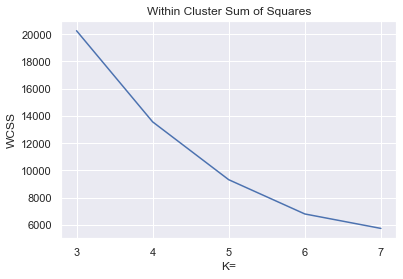

In [189]:
# use data_df 

from sklearn.cluster import KMeans


X = list(zip(data_df.LATITUDE,data_df.LONGITUDE))

from sklearn.metrics import calinski_harabasz_score
k_means_3 = KMeans(n_clusters=3).fit(X)
k_means_4 = KMeans(n_clusters=4).fit(X)
k_means_5 = KMeans(n_clusters=5).fit(X)
k_means_6 = KMeans(n_clusters=6).fit(X)
k_means_7 = KMeans(n_clusters=7).fit(X)

k_list = [k_means_3, k_means_4, k_means_5, k_means_6, k_means_7]

wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

    
plt.plot([3, 4, 5, 6, 7], wcss_score)
plt.xticks([3,4,5,6,7])
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

In [190]:
data_df['clusters'] = k_means_6.predict(X)

cluster_cause_df = data_df[['clusters','STAT_CAUSE_DESCR']]

from collections import Counter

causes_cluster_dict_list = [{i: Counter(cluster_cause_df[cluster_cause_df.STAT_CAUSE_DESCR == i].clusters)}
                       for i in set(cluster_cause_df.STAT_CAUSE_DESCR)]

causes_cluster_dict_list

<ipython-input-190-ef8d91d49b6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['clusters'] = k_means_6.predict(X)


[{'Children': Counter({0: 13, 3: 23, 4: 21, 5: 4, 2: 17, 1: 8})},
 {'Railroad': Counter({0: 10, 4: 5, 3: 6, 5: 9, 2: 1, 1: 9})},
 {'Miscellaneous': Counter({0: 545, 4: 403, 3: 505, 5: 85, 1: 384, 2: 187})},
 {'Lightning': Counter({0: 92, 4: 39, 3: 55, 5: 123, 2: 141, 1: 186})},
 {'Debris Burning': Counter({4: 323, 0: 565, 3: 517, 5: 16, 2: 479, 1: 61})},
 {'Smoking': Counter({4: 28, 0: 57, 3: 73, 5: 16, 2: 33, 1: 23})},
 {'Campfire': Counter({4: 17, 0: 28, 3: 19, 5: 1, 2: 17, 1: 7})},
 {'Powerline': Counter({4: 61, 0: 116, 3: 114, 5: 50, 1: 139, 2: 102})},
 {'Arson': Counter({4: 46, 0: 104, 3: 102, 5: 18, 1: 15, 2: 156})},
 {'Fireworks': Counter({2: 2})},
 {'Equipment Use': Counter({4: 221, 0: 286, 3: 247, 5: 109, 1: 290, 2: 52})}]

In [191]:
values_normal = []
clusters = list(range(4))

for i in causes_cluster_dict_list:
    for k, v in i.items():
        #stats.zscore(list(v.values()))
        values_normal.append(stats.zscore(list(v.values())))


causes = set(cluster_cause_df.STAT_CAUSE_DESCR)


dict_1_list = []

for i in values_normal:
        dict_1_list.append(dict(zip(clusters,i)))
        
causes_cluster_dict_normalized = dict(zip(causes, dict_1_list))

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [192]:
for cause in set(cluster_cause_df.STAT_CAUSE_DESCR):

    for k, v in causes_cluster_dict_normalized[cause].items():
        if v <= -1.5:
            print('Fires from ', cause, ' mostly NOT found in cluster ', k)
        elif v >= 1.5:
            print('Fires from ', cause, ' mostly ARE found in cluster ', k)
        else:
            None

Fires from  Children  mostly NOT found in cluster  3
Fires from  Miscellaneous  mostly NOT found in cluster  3
Fires from  Smoking  mostly ARE found in cluster  2
Fires from  Campfire  mostly ARE found in cluster  1
Fires from  Campfire  mostly NOT found in cluster  3


Get Distances of from all clusters as a feature. One of the drawbacks of this is that this won't generalize to states outside of TEXAS. 

In [193]:
data_df['LAT_radians'] = np.radians(data_df['LATITUDE'])

data_df['LONG_radians'] = np.radians(data_df['LONGITUDE'])


<ipython-input-193-258346018248>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['LAT_radians'] = np.radians(data_df['LATITUDE'])
<ipython-input-193-258346018248>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['LONG_radians'] = np.radians(data_df['LONGITUDE'])


In [194]:
[np.radians(i) for i in k_means_6.cluster_centers_]

[array([ 0.55506468, -1.70826023]),
 array([ 0.5519876 , -1.78432694]),
 array([ 0.54105207, -1.64847598]),
 array([ 0.58130707, -1.6818102 ]),
 array([ 0.51896556, -1.72364758]),
 array([ 0.60843555, -1.76063632])]

In [195]:
data_df['LAT_radians'],data_df['LONG_radians']

(1470827    0.523599
 1470830    0.523599
 1524362    0.523599
 1524378    0.523599
 1524381    0.523599
              ...   
 1563776    0.541052
 1563777    0.541052
 1563781    0.558505
 1563784    0.558505
 1563788    0.558505
 Name: LAT_radians, Length: 7381, dtype: float64,
 1470827   -1.710423
 1470830   -1.710423
 1524362   -1.710423
 1524378   -1.710423
 1524381   -1.710423
              ...   
 1563776   -1.710423
 1563777   -1.710423
 1563781   -1.710423
 1563784   -1.710423
 1563788   -1.710423
 Name: LONG_radians, Length: 7381, dtype: float64)

In [196]:
def haversian(lat1, lon1, lat2, lon2):
    
    R = 6373.0
    
    dlon = lon2 - lon1

    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [197]:
cluster_geo_dict = dict(enumerate([np.radians(i)
                                   for i in k_means_6.cluster_centers_]))

lat_long_radians = list(
    zip(np.radians(data_df.LATITUDE), np.radians(data_df.LONGITUDE)))


# get this into a form to make columns easier....
# make cluster geo a dictionary an unpack the dictionary,reuse keys which are indexes

for k_num in range(6):
    data_df['dist_cluster_'+str(k_num)] = [haversian(
        i[0], i[-1], cluster_geo_dict[k_num][1], cluster_geo_dict[k_num][-1]) for i in lat_long_radians]

<ipython-input-197-09d0bad16baa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['dist_cluster_'+str(k_num)] = [haversian(


In [198]:
cluster_column_names = ['dist_cluster_'+str(i) for i in range(6)]

cluster_column_names

['dist_cluster_0',
 'dist_cluster_1',
 'dist_cluster_2',
 'dist_cluster_3',
 'dist_cluster_4',
 'dist_cluster_5']





# Logistic Classifier

### Class Imbalances

In [199]:
data_df.STAT_CAUSE_DESCR.value_counts(normalize = True)


Miscellaneous     0.285734
Debris Burning    0.265682
Equipment Use     0.163257
Lightning         0.086167
Powerline         0.078851
Arson             0.059748
Smoking           0.031161
Campfire          0.012058
Children          0.011652
Railroad          0.005419
Fireworks         0.000271
Name: STAT_CAUSE_DESCR, dtype: float64

In [200]:
print('Debris Burning: ',sum(data_df.STAT_CAUSE_DESCR == 'Debris Burning')/len(data_df))

print('not Debris Burning: ',sum(data_df.STAT_CAUSE_DESCR != 'Debris Burning')/len(data_df))

Debris Burning:  0.2656821568893104
not Debris Burning:  0.7343178431106896


## Single Class  - Classifying Debris Burning

Was it debris burning, or was it not debris burning?

In [201]:
target = data_df.STAT_CAUSE_DESCR == 'Debris Burning'

data_df['target'] = [int(i) for i in target.values]

<ipython-input-201-eb813113346c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(i) for i in target.values]


In [202]:
data_df['month'] = [i.month for i in pd.to_datetime(data_df['DISCOVERY_DATE'].values)]

<ipython-input-202-b9ce9b5584a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['month'] = [i.month for i in pd.to_datetime(data_df['DISCOVERY_DATE'].values)]


In [203]:
data_df.head()

,OBJECTID,STATE,LATITUDE,LONGITUDE,LAT_LONG,NOAA,DISCOVERY_DATE,DURATION,year,TMAX,...,clusters,LAT_radians,LONG_radians,dist_cluster_0,dist_cluster_1,dist_cluster_2,dist_cluster_3,dist_cluster_4,dist_cluster_5,target
1470827,1470828,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-04-06,0,2011,222.0,...,4,0.523599,-1.710423,14223.635184,14704.09995,13841.636214,14054.760597,14321.606817,14555.694304,0
1470830,1470831,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-03-09,0,2011,239.0,...,4,0.523599,-1.710423,14223.635184,14704.09995,13841.636214,14054.760597,14321.606817,14555.694304,0
1524362,1524363,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-01-06,0,2011,139.0,...,4,0.523599,-1.710423,14223.635184,14704.09995,13841.636214,14054.760597,14321.606817,14555.694304,0
1524378,1524379,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-01-19,1,2011,106.0,...,4,0.523599,-1.710423,14223.635184,14704.09995,13841.636214,14054.760597,14321.606817,14555.694304,0
1524381,1524382,TX,30.0,-98.0,"(30.0, -98.0)",GHCND:USC00345563,2011-01-25,0,2011,128.0,...,4,0.523599,-1.710423,14223.635184,14704.09995,13841.636214,14054.760597,14321.606817,14555.694304,1


### Baseline Model (without exogenous features)

#### y

In [204]:
y = data_df.target

#### X

####  Continous Features

In [205]:
continous = ['LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'FIRE_SIZE']

#### Categorical Features

In [206]:
categorical = ['month']

X_categorical = pd.get_dummies(data_df[categorical], prefix='month')

###  Normalize the data

In [207]:
X_continous = data_df[continous].fillna(value=0)

for column in X_continous.columns:

    # Subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

    X_continous[column] = (X_continous[column] - min(X_continous[column])) / \
        (max(X_continous[column]) - min(X_continous[column]))

### Concatenate continous and categorical dataframes

In [208]:
X = pd.concat([X_continous,X_categorical], axis = 1)

##  Train-Test Split

In [209]:
### Class Imbalance Requires SMOTE

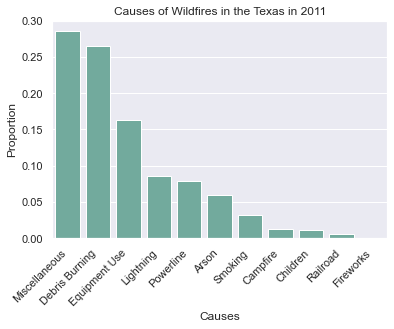

In [210]:
barplot_df = pd.DataFrame({'Causes': list(data_df.STAT_CAUSE_DESCR.value_counts(
    normalize=True).index), 'Proportion': list(data_df.STAT_CAUSE_DESCR.value_counts(normalize=True).values)})


barplot_df = barplot_df.sort_values(
    ['Proportion'], ascending=False).reset_index(drop=True)

chart = sns.barplot(
    x='Causes',
    y='Proportion',
    data=barplot_df,
    estimator=sum,
    ci=None,

    color='#69b3a2'
)


chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45, horizontalalignment='right')
plt.title('Causes of Wildfires in the Texas in 2011');

In [211]:
#deal with imbalances

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

## Fit the model

In [212]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

model_log = logreg.fit(X_train_resampled, y_train_resampled)

 ## Predict

In [213]:
y_hat_train = model_log.predict(X_train)

y_hat_test = model_log.predict(X_test)

## How many times was the classifier correct on the training set?

In [214]:
residuals = np.abs(y_train - y_hat_train)


print(pd.Series(residuals).value_counts(normalize=True))

0    0.62168
1    0.37832
Name: target, dtype: float64


## How many times was the classifier correct on the testing set?

In [215]:
residuals = np.abs(y_test - y_hat_test)


print(pd.Series(residuals).value_counts(normalize=True))

0    0.638137
1    0.361863
Name: target, dtype: float64


## Model with One Exogenous Feature

In [216]:
continous = ['LATITUDE', 'LONGITUDE',
             'DISCOVERY_DOY', 'DISCOVERY_TIME', 'TMAX', 'FIRE_SIZE']

X_continous = data_df[continous].fillna(value=0)

for column in X_continous.columns:

    X_continous[column] = (X_continous[column] - min(X_continous[column])) / \
        (max(X_continous[column]) - min(X_continous[column]))

X = pd.concat([X_continous, X_categorical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

model_log = logreg.fit(X_train_resampled, y_train_resampled)

y_hat_train = model_log.predict(X_train)

y_hat_test = model_log.predict(X_test)


residuals = np.abs(y_train - y_hat_train)


print(pd.Series(residuals).value_counts(normalize=True))

print('\n')

residuals = np.abs(y_test - y_hat_test)


print(pd.Series(residuals).value_counts(normalize=True))

0    0.692141
1    0.307859
Name: target, dtype: float64


0    0.691766
1    0.308234
Name: target, dtype: float64


---------------------------------------

# Get Rid of Classes Less than 6 or SMOTE Fails

In [217]:
data_df.STAT_CAUSE_DESCR.value_counts()

Miscellaneous     2109
Debris Burning    1961
Equipment Use     1205
Lightning          636
Powerline          582
Arson              441
Smoking            230
Campfire            89
Children            86
Railroad            40
Fireworks            2
Name: STAT_CAUSE_DESCR, dtype: int64

In [218]:
data_df = data_df[data_df.STAT_CAUSE_DESCR != 'Fireworks']

# Building a Model for Every Wildfire Cause

In [222]:
for i in set(data_df.STAT_CAUSE_DESCR):
 
    array = data_df.STAT_CAUSE_DESCR == i

    data_df['target'] = [int(j) for j in array] 
    
    y = data_df.target

    continous = ['LATITUDE', 'LONGITUDE',
                 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'TMAX', 'FIRE_SIZE']

    X_continous = data_df[continous].fillna(value=0)

    for column in X_continous.columns:

        X_continous[column] = (X_continous[column] - min(X_continous[column]))
        (max(X_continous[column]) - min(X_continous[column]))

    X_categorical = pd.get_dummies(data_df[categorical], prefix='month')

    X = pd.concat([X_continous, X_categorical], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    smote = SMOTE()

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    logreg = LogisticRegression(
        fit_intercept=False, C=1e12, solver='liblinear')

    model_log = logreg.fit(X_train_resampled, y_train_resampled)

    y_hat_train = model_log.predict(X_train)

    y_hat_test = model_log.predict(X_test)

    # residuals = np.abs(y_train - y_hat_train)

    # print(pd.Series(residuals).value_counts(normalize=True))

    residuals = np.abs(y_test - y_hat_test)

    print(i, '  ', round(pd.Series(residuals).value_counts(normalize=True)[0],2))

<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Children    0.67
Railroad    0.72
Miscellaneous    0.53


<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Lightning    0.73
Debris Burning    0.68
Smoking    0.59


<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Campfire    0.7
Powerline    0.58
Arson    0.63
Equipment Use    0.63


<ipython-input-222-d35e000b6ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]


# Model with one exogenous feature and features derived form unsupervised learning

In [223]:
# remember to normalize continous features

for i in set(data_df.STAT_CAUSE_DESCR):

    array = data_df.STAT_CAUSE_DESCR == i

    data_df['target'] = [int(j) for j in array]

    y = data_df.target

    continous = ['LATITUDE', 'LONGITUDE',
                 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'TMAX', 'FIRE_SIZE','dist_cluster_0', 
                 'dist_cluster_1',
                 'dist_cluster_2',
                 'dist_cluster_3',
                 'dist_cluster_4',
                 'dist_cluster_5']

    X_continous = data_df[continous].fillna(value=0)

    for column in X_continous.columns:

        X_continous[column] = (X_continous[column] - min(X_continous[column]))
        (max(X_continous[column]) - min(X_continous[column]))

    X_categorical = pd.get_dummies(data_df[categorical], prefix='month')

    X = pd.concat([X_continous, X_categorical], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    smote = SMOTE()

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    logreg = LogisticRegression(
        fit_intercept=False, C=1e12, solver='liblinear')

    model_log = logreg.fit(X_train_resampled, y_train_resampled)

    y_hat_train = model_log.predict(X_train)

    y_hat_test = model_log.predict(X_test)

    # residuals = np.abs(y_train - y_hat_train)

    # print(pd.Series(residuals).value_counts(normalize=True))

    residuals = np.abs(y_test - y_hat_test)

    print(i, '  ', round(
        pd.Series(residuals).value_counts(normalize=True)[0], 2))

<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]


Children    0.7
Railroad    0.75


<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]


Miscellaneous    0.52
Lightning    0.77


<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]


Debris Burning    0.67
Smoking    0.66


<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]


Campfire    0.74
Powerline    0.61


<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]
<ipython-input-223-9fe8d884eb5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = [int(j) for j in array]


Arson    0.66
Equipment Use    0.63


-----------------------------------------------------------------------------

# Results

In [89]:
#One Exogenous Variable


Children          0.67
Railroad          0.72
Miscellaneous     0.53
Lightning         0.73
Debris Burning    0.68
Smoking           0.59
Campfire          0.7
Powerline         0.58
Arson             0.63
Equipment Use     0.63


SyntaxError: invalid syntax (<ipython-input-89-a9b30feca3e9>, line 4)

In [ ]:
#With Distance from Clusters As Feature:


Children          0.7
Railroad          0.75
Miscellaneous     0.52
Lightning         0.77
Debris Burning    0.67
Smoking           0.66
Campfire          0.74
Powerline         0.61
Arson             0.66
Equipment Use     0.63

----------------